In [233]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [234]:
HOST_IPS = {'10.194.224.177', '192.168.0.48', '192.168.0.132'}

insta = pd.read_csv('./data/instagram_packet_log.csv')
reddit = pd.read_csv('./data/reddit_packet_log.csv')
tetris = pd.read_csv('./data/tetris_packet_log.csv')
wiki = pd.read_csv('./data/wikipedia_packet_log.csv')
wyr = pd.read_csv('./data/wouldyourather_packet_log.csv')
yt = pd.read_csv('./data/youtube_packet_log.csv')
chat = pd.read_csv('./data/chat_gpt_packet_log.csv')
spotify = pd.read_csv('./data/spotify_packet_log.csv')

datasets = {
    "instagram": insta,
    "reddit": reddit,
    "tetris": tetris,
    "wikipedia": wiki,
    "wouldyourather": wyr,
    "yt": yt,
    "chat_gpt": chat,
    "spotify": spotify
}

In [235]:
def preprocess(df):
    df['Direction'] = df['Destination IP'].apply(lambda ip: 'Incoming' if ip in HOST_IPS else 'Outgoing')
    df = df.copy()
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [236]:
def extract_features(df, dataset_name):
    df = preprocess(df)
    results = []
    
    start_time = df['Timestamp'].min()
    end_time = df['Timestamp'].max()

    current_start = start_time
    while current_start < end_time:
        current_end = current_start + timedelta(seconds=7)
        window_df = df[(df['Timestamp'] >= current_start) & (df['Timestamp'] < current_end)]

        if window_df.empty:
            current_start = current_end
            continue

        sent = window_df[window_df['Source IP'].isin(HOST_IPS)]
        recv = window_df[window_df['Destination IP'].isin(HOST_IPS)]

        avg_packet_size_sent = sent['Length'].mean() if not sent.empty else 0
        sd_packet_size_sent = sent['Length'].std() if not sent['Length'].std() else 0

        avg_packet_size_recv = recv['Length'].mean() if not recv.empty else 0
        sd_packet_size_recv = recv['Length'].std() if not recv['Length'].std() else 0

        def time_deltas(packets):
            times = packets['Timestamp'].sort_values().values
            if len(times) < 2:
                return 0.0, 0.0
            deltas = np.diff(times) / np.timedelta64(1, 's')
            return np.mean(deltas), np.std(deltas)

        avg_time_between_outgoing, sd_time_between_outgoing = time_deltas(sent) if not sent.empty else (0.0, 0.0)
        avg_time_between_incoming, sd_time_between_incoming = time_deltas(recv) if not recv.empty else (0.0, 0.0)

        number_outgoing = len(sent)
        number_incoming = len(recv)
        ratio_incoming_to_outgoing = number_incoming / number_outgoing if number_outgoing > 0 else np.nan
        ratio_outgoing_to_incoming = number_outgoing / number_incoming if number_incoming > 0 else np.nan

        results.append({
            "avg_packet_size_sent": avg_packet_size_sent,
            # "sd_packet_size_sent": sd_packet_size_sent,
            "avg_packet_size_recv": avg_packet_size_recv,
            # "sd_packet_size_recv": sd_packet_size_recv,
            "avg_time_between_outgoing_packets": avg_time_between_outgoing,
            # "sd_time_between_outgoing_packets": sd_time_between_outgoing,
            "avg_time_between_incoming_packets": avg_time_between_incoming,
            # "sd_time_between_incoming_packets": sd_time_between_incoming,
            # "ratio_incoming_to_outgoing": ratio_incoming_to_outgoing,
            "ratio_outgoing_to_incoming": ratio_outgoing_to_incoming,
            "number_incoming": number_incoming,
            "number_outgoing": number_outgoing,
            "dataset": dataset_name
        })

        current_start = current_end

    return results
# def extract_features(df, dataset_name):
#     df = preprocess(df)
#     results = []
    
#     # Sort the DataFrame by Timestamp
#     df = df.sort_values(by="Timestamp")
    
#     for idx, row in df.iterrows():
#         current_time = row['Timestamp']
#         current_start = current_time - timedelta(seconds=1)
#         current_end = current_time
        
#         # Get the subset of data within the 10-second window before the current timestamp
#         window_df = df[(df['Timestamp'] >= current_start) & (df['Timestamp'] < current_end)]
        
#         if window_df.empty:
#             continue
        
#         # Filter for outgoing and incoming packets based on host IPs
#         sent = window_df[window_df['Source IP'].isin(HOST_IPS)]
#         recv = window_df[window_df['Destination IP'].isin(HOST_IPS)]
        
#         # Calculate packet sizes and standard deviations
#         avg_packet_size_sent = sent['Length'].mean() if not sent.empty else 0
#         sd_packet_size_sent = sent['Length'].std() if not sent.empty else 0
        
#         avg_packet_size_recv = recv['Length'].mean() if not recv.empty else 0
#         sd_packet_size_recv = recv['Length'].std() if not recv.empty else 0

#         def time_deltas(packets):
#             times = packets['Timestamp'].sort_values().values
#             if len(times) < 2:
#                 return 0.0, 0.0
#             deltas = np.diff(times) / np.timedelta64(1, 's')
#             return np.mean(deltas), np.std(deltas)
        
#         avg_time_between_outgoing, sd_time_between_outgoing = time_deltas(sent) if not sent.empty else (0.0, 0.0)
#         avg_time_between_incoming, sd_time_between_incoming = time_deltas(recv) if not recv.empty else (0.0, 0.0)
        
#         number_outgoing = len(sent)
#         number_incoming = len(recv)
        
#         ratio_incoming_to_outgoing = number_incoming / number_outgoing if number_outgoing > 0 else np.nan
#         ratio_outgoing_to_incoming = number_outgoing / number_incoming if number_incoming > 0 else np.nan
        
#         results.append({
#             "avg_packet_size_sent": avg_packet_size_sent,
#             "avg_packet_size_recv": avg_packet_size_recv,
#             "avg_time_between_outgoing_packets": avg_time_between_outgoing,
#             "avg_time_between_incoming_packets": avg_time_between_incoming,
#             "ratio_outgoing_to_incoming": ratio_outgoing_to_incoming,
#             "number_incoming": number_incoming,
#             "number_outgoing": number_outgoing,
#             "dataset": dataset_name
#         })
    
#     return results


In [237]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_traffic(df, title, color='blue'):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Filter incoming and outgoing traffic
    incoming_df = df[df['Direction'] == 'Incoming']
    outgoing_df = df[df['Direction'] == 'Outgoing']
    
    # Create the subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(35, 12))

    # Plot Incoming Traffic
    for direction, group in incoming_df.groupby('Direction'):
        ax1.plot(group['Timestamp'], group['Length'], label=direction, color=color)
    ax1.set_title(f'Incoming Traffic for {title}')
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Message Size (Bytes)')
    ax1.legend()
    ax1.grid(True)

    # Plot Outgoing Traffic
    for direction, group in outgoing_df.groupby('Direction'):
        ax2.plot(group['Timestamp'], group['Length'], label=direction, color=color)
    ax2.set_title(f'Outgoing Traffic for {title}')
    ax2.set_xlabel('Timestamp')
    ax2.set_ylabel('Message Size (Bytes)')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout and rotate x-axis labels
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()


In [238]:
all_features = []

for name, df in datasets.items():
    df = preprocess(df)
    features = extract_features(df, name)
    all_features.extend(features)

features_df = pd.DataFrame(all_features)

In [239]:
insta = preprocess(insta)
insta.head(100)

Timestamp       Source IP  Destination IP Protocol  \
0  2025-05-01 17:44:25.692769    192.168.0.48  157.240.254.63      TLS   
1  2025-05-01 17:44:25.692775    192.168.0.48  157.240.254.63      TLS   
2  2025-05-01 17:44:25.700636  157.240.254.63    192.168.0.48      TLS   
3  2025-05-01 17:44:25.700638  157.240.254.63    192.168.0.48      TLS   
4  2025-05-01 17:44:25.700640  157.240.254.63    192.168.0.48      TLS   
..                        ...             ...             ...      ...   
95 2025-05-01 17:44:26.349783   150.171.22.12    192.168.0.48      TLS   
96 2025-05-01 17:44:26.349784   150.171.22.12    192.168.0.48      TLS   
97 2025-05-01 17:44:26.353767  157.240.254.63    192.168.0.48      TLS   
98 2025-05-01 17:44:26.353770  157.240.254.63    192.168.0.48      TLS   
99 2025-05-01 17:44:26.354735    192.168.0.48  157.240.254.63      TLS   

    Length Direction  
0     1446  Outgoing  
1      471  Outgoing  
2     1446  Incoming  
3     1446  Incoming  
4      275  Incoming  
..     ...       ...  
95     537  Incoming  
96      85  Incoming  
97      96  Incoming  
98      96  Incoming  
99     198  Outgoing  

[100 rows x 6 columns]

In [240]:
features_df.isna().sum()
features_df.dropna(inplace=True)

In [241]:
features_df.to_csv('network_traffic_features.csv', index=False)

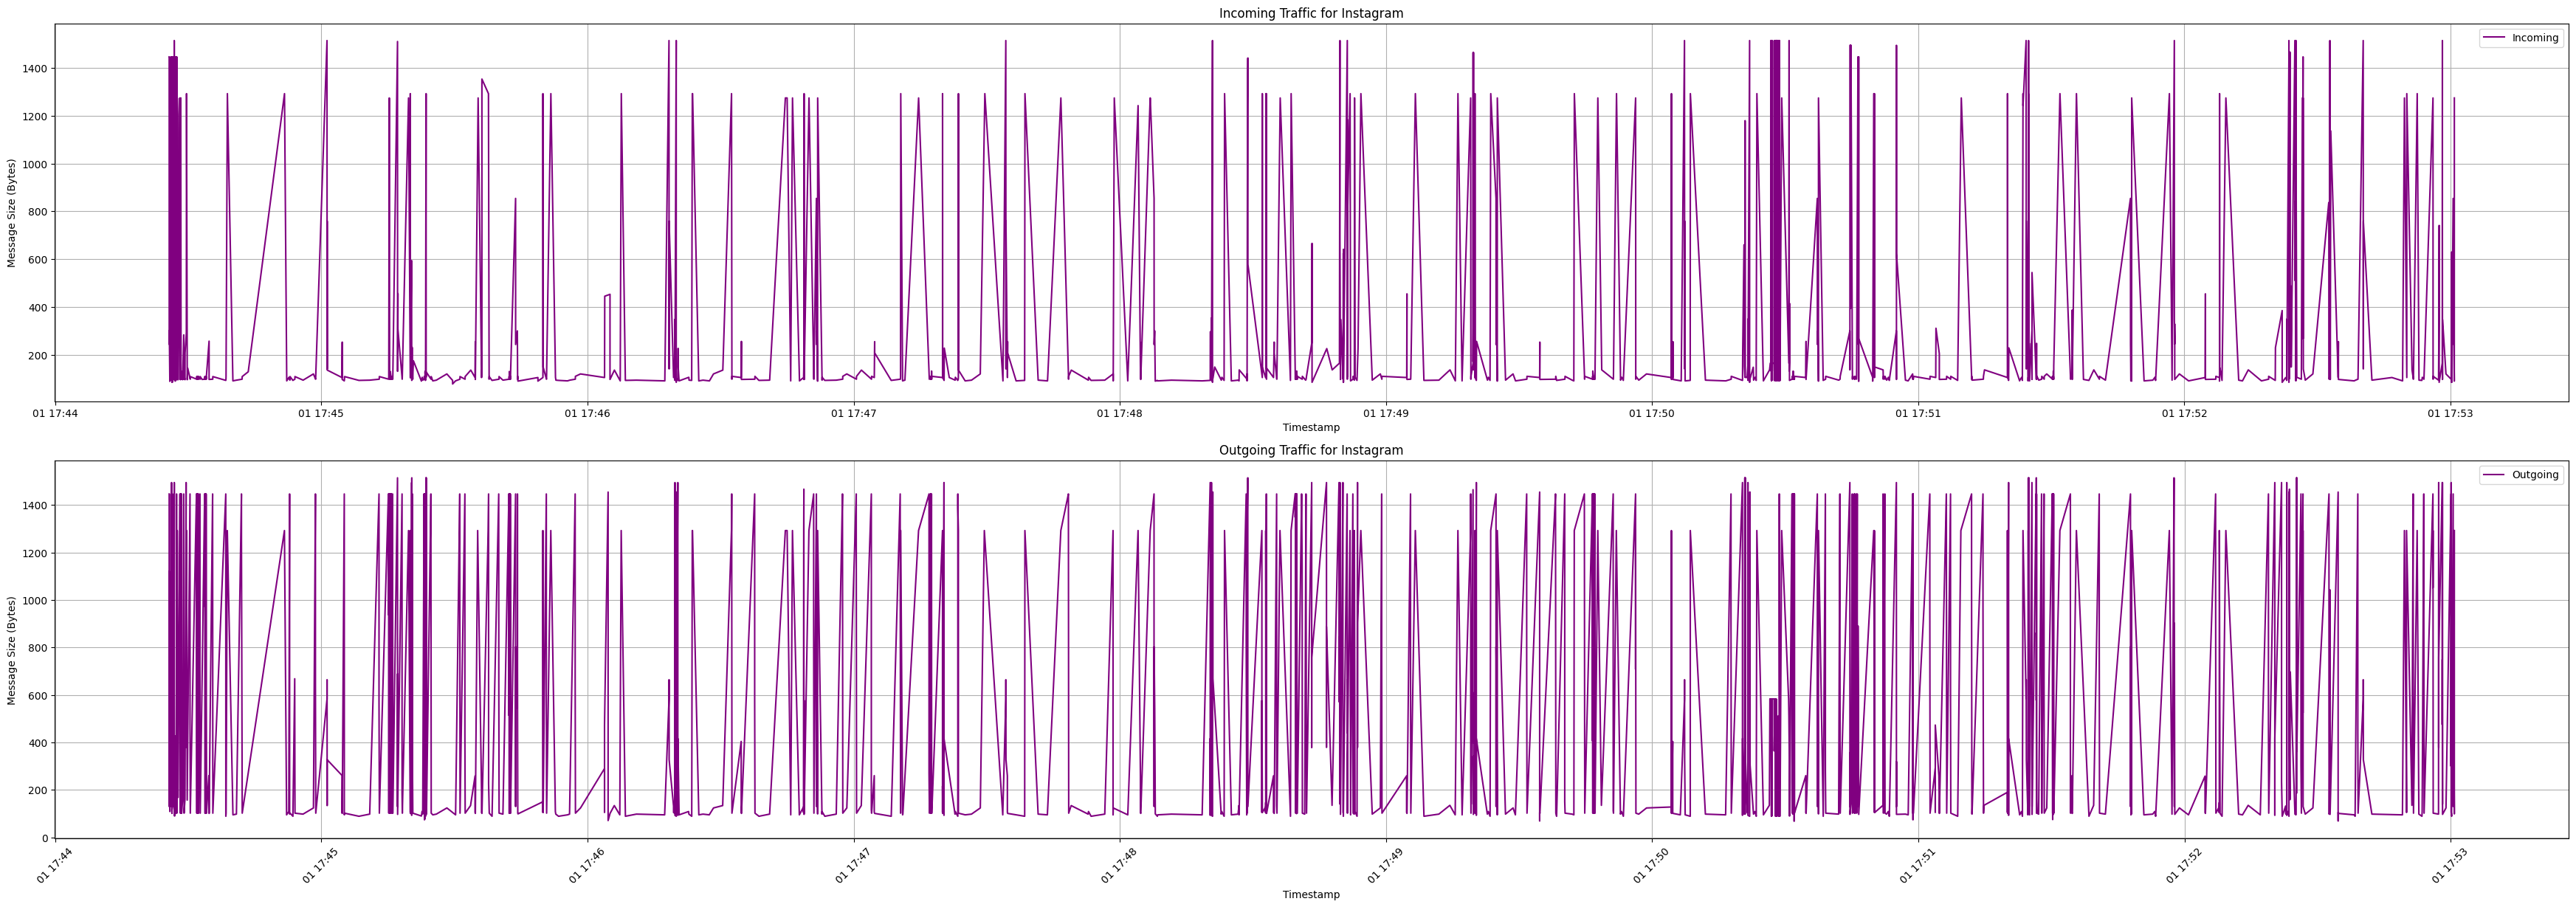

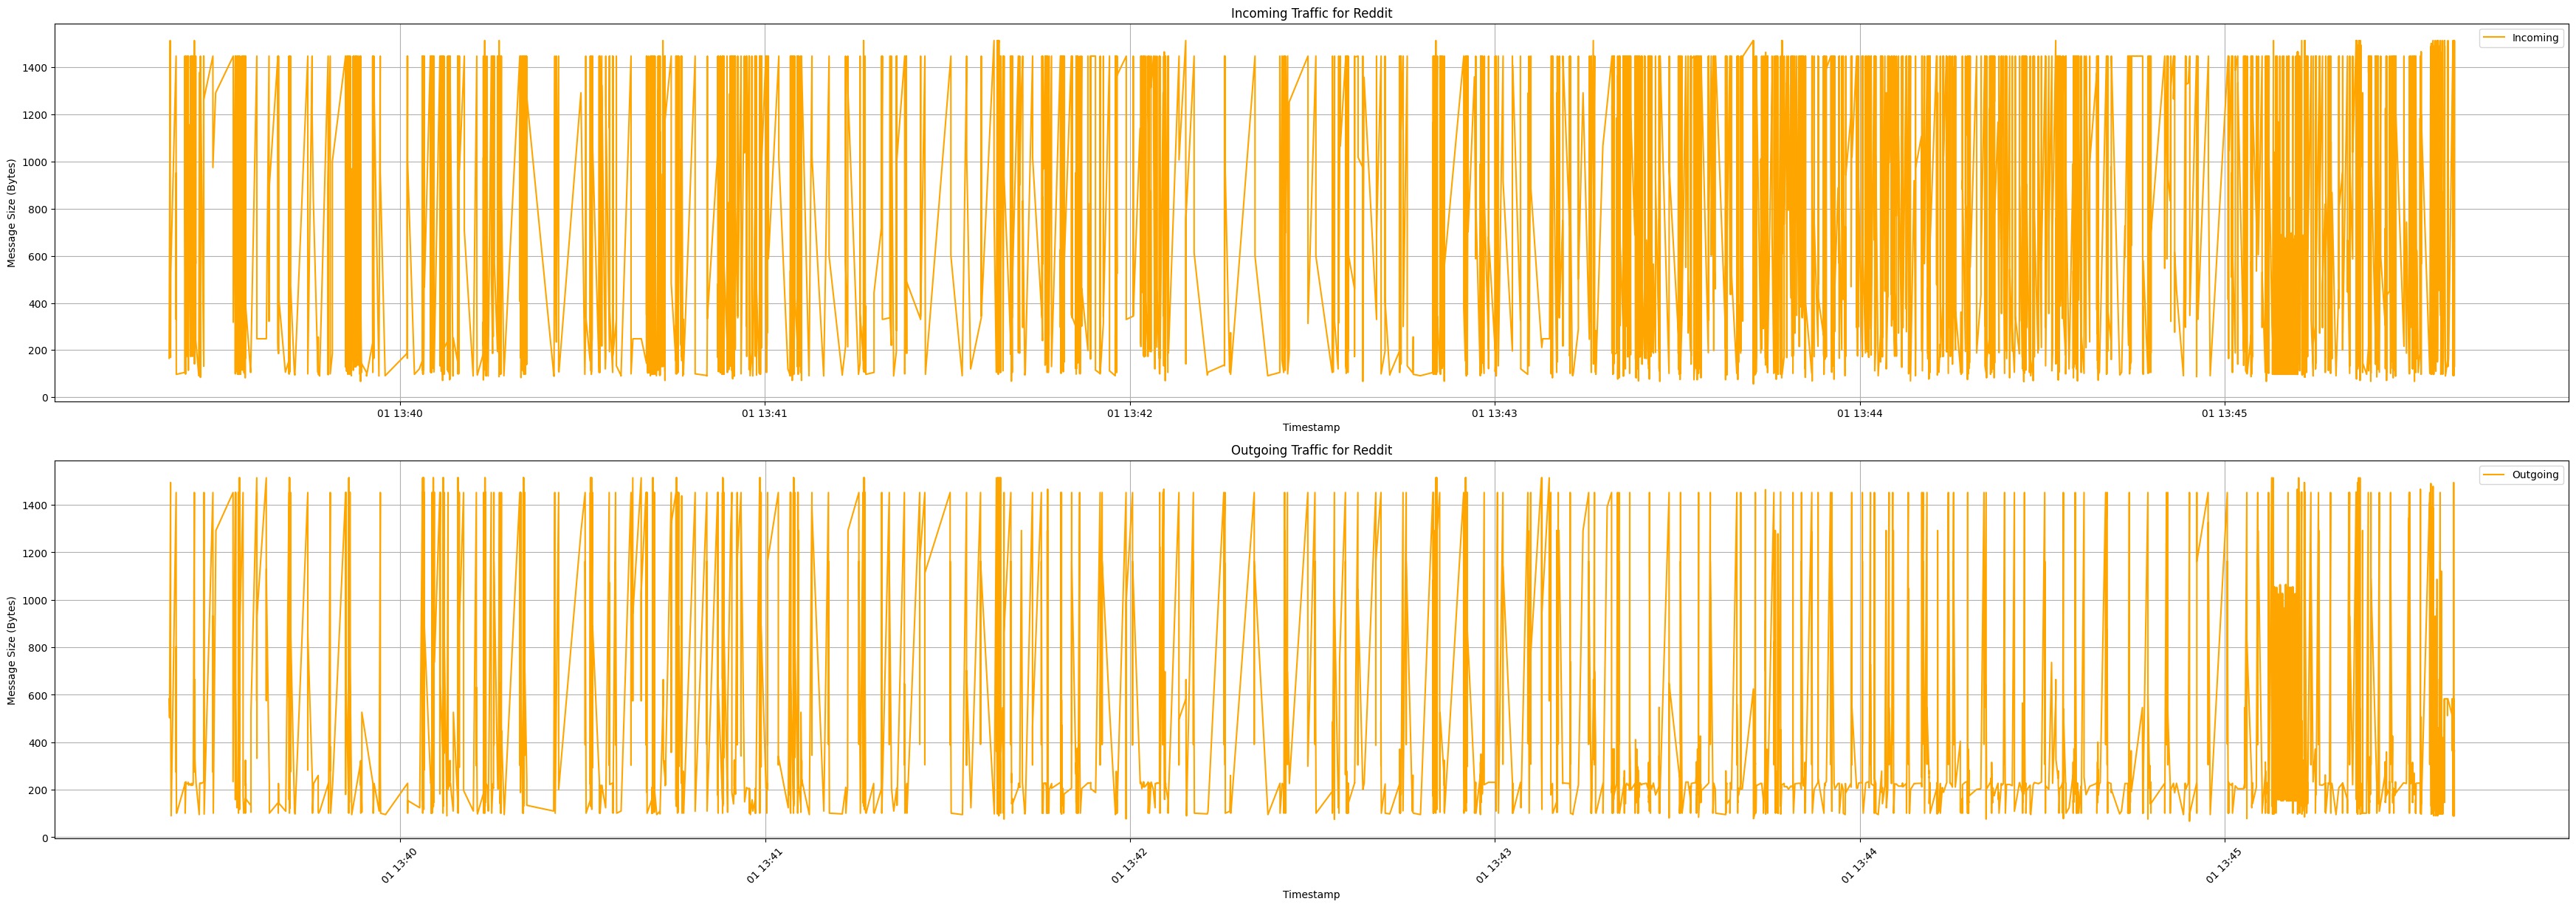

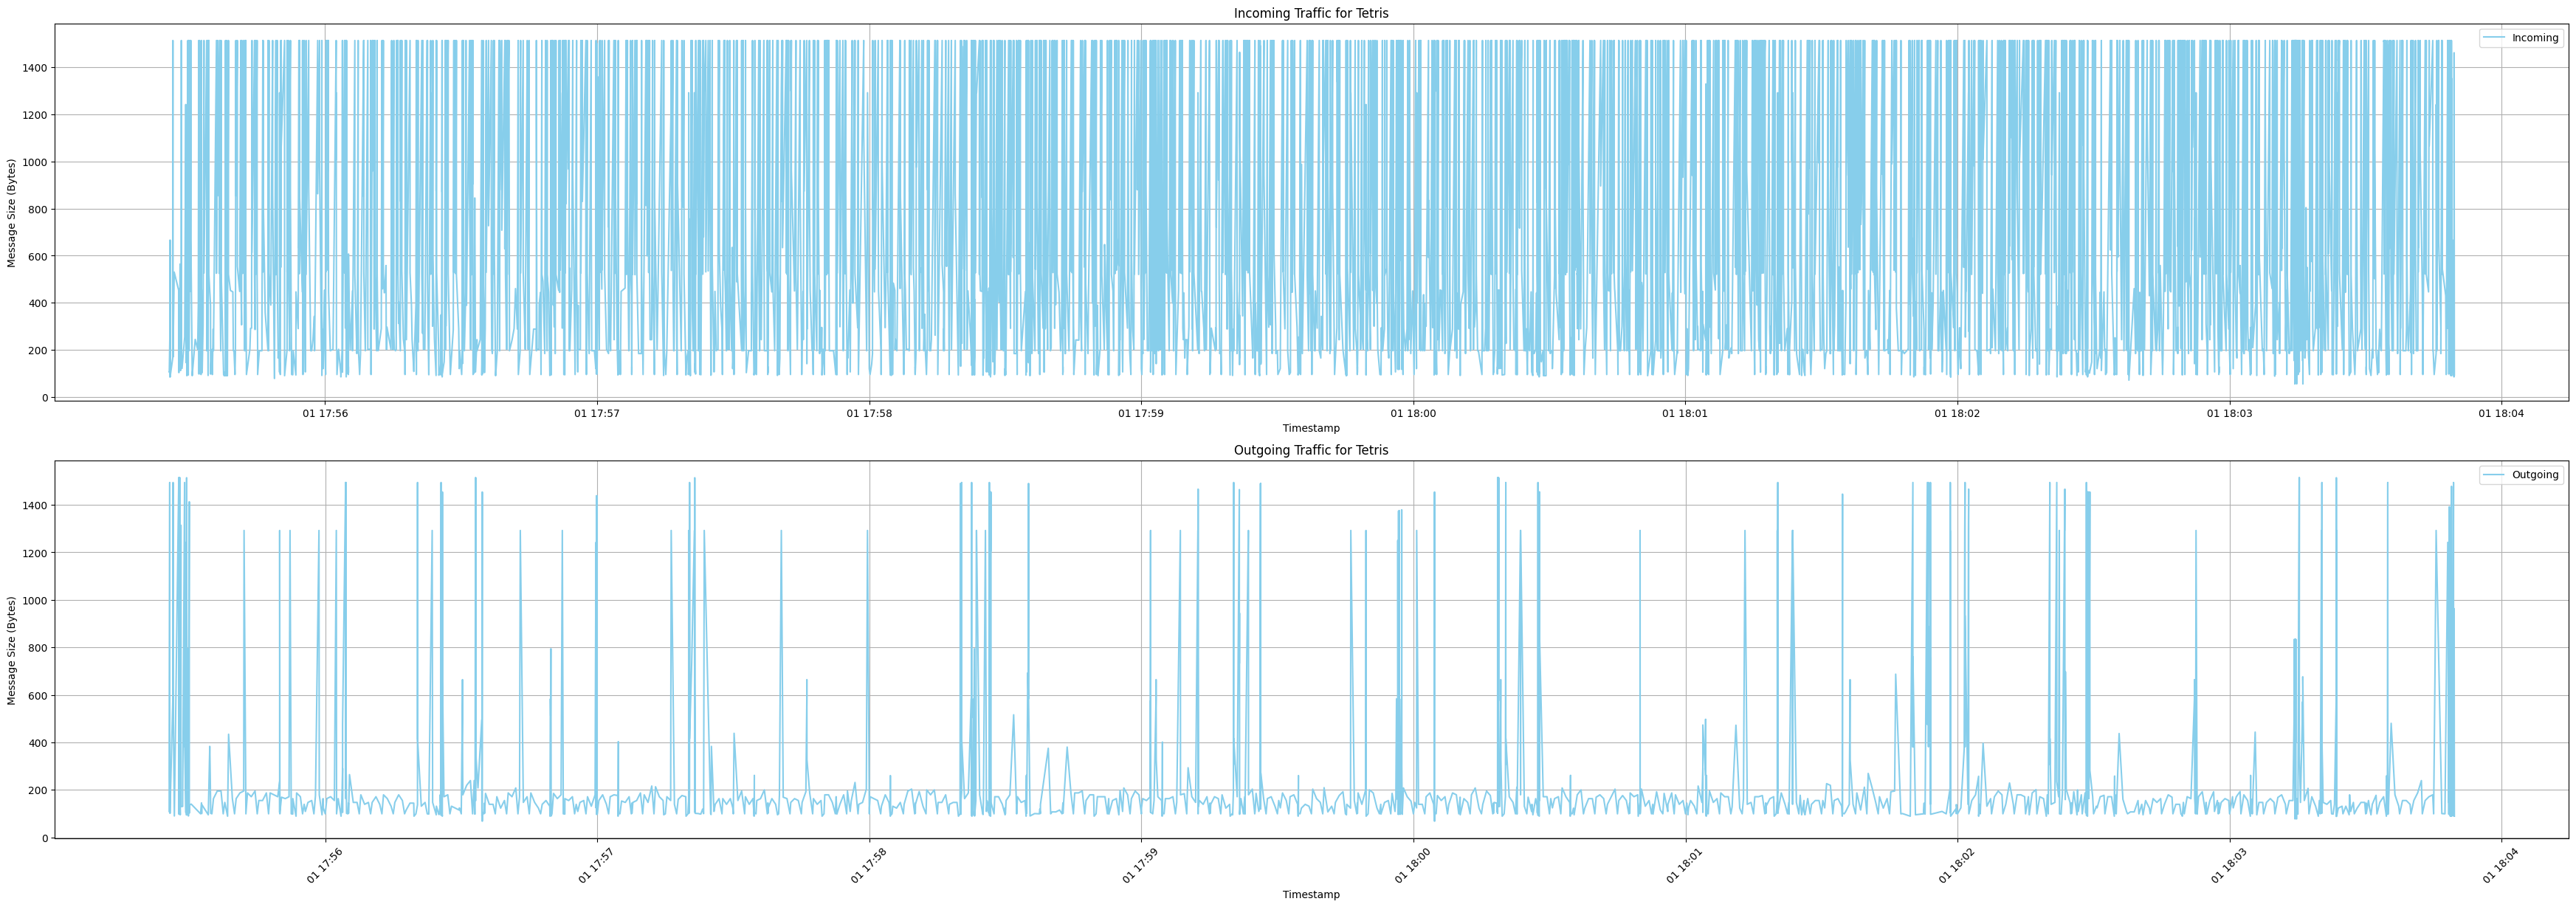

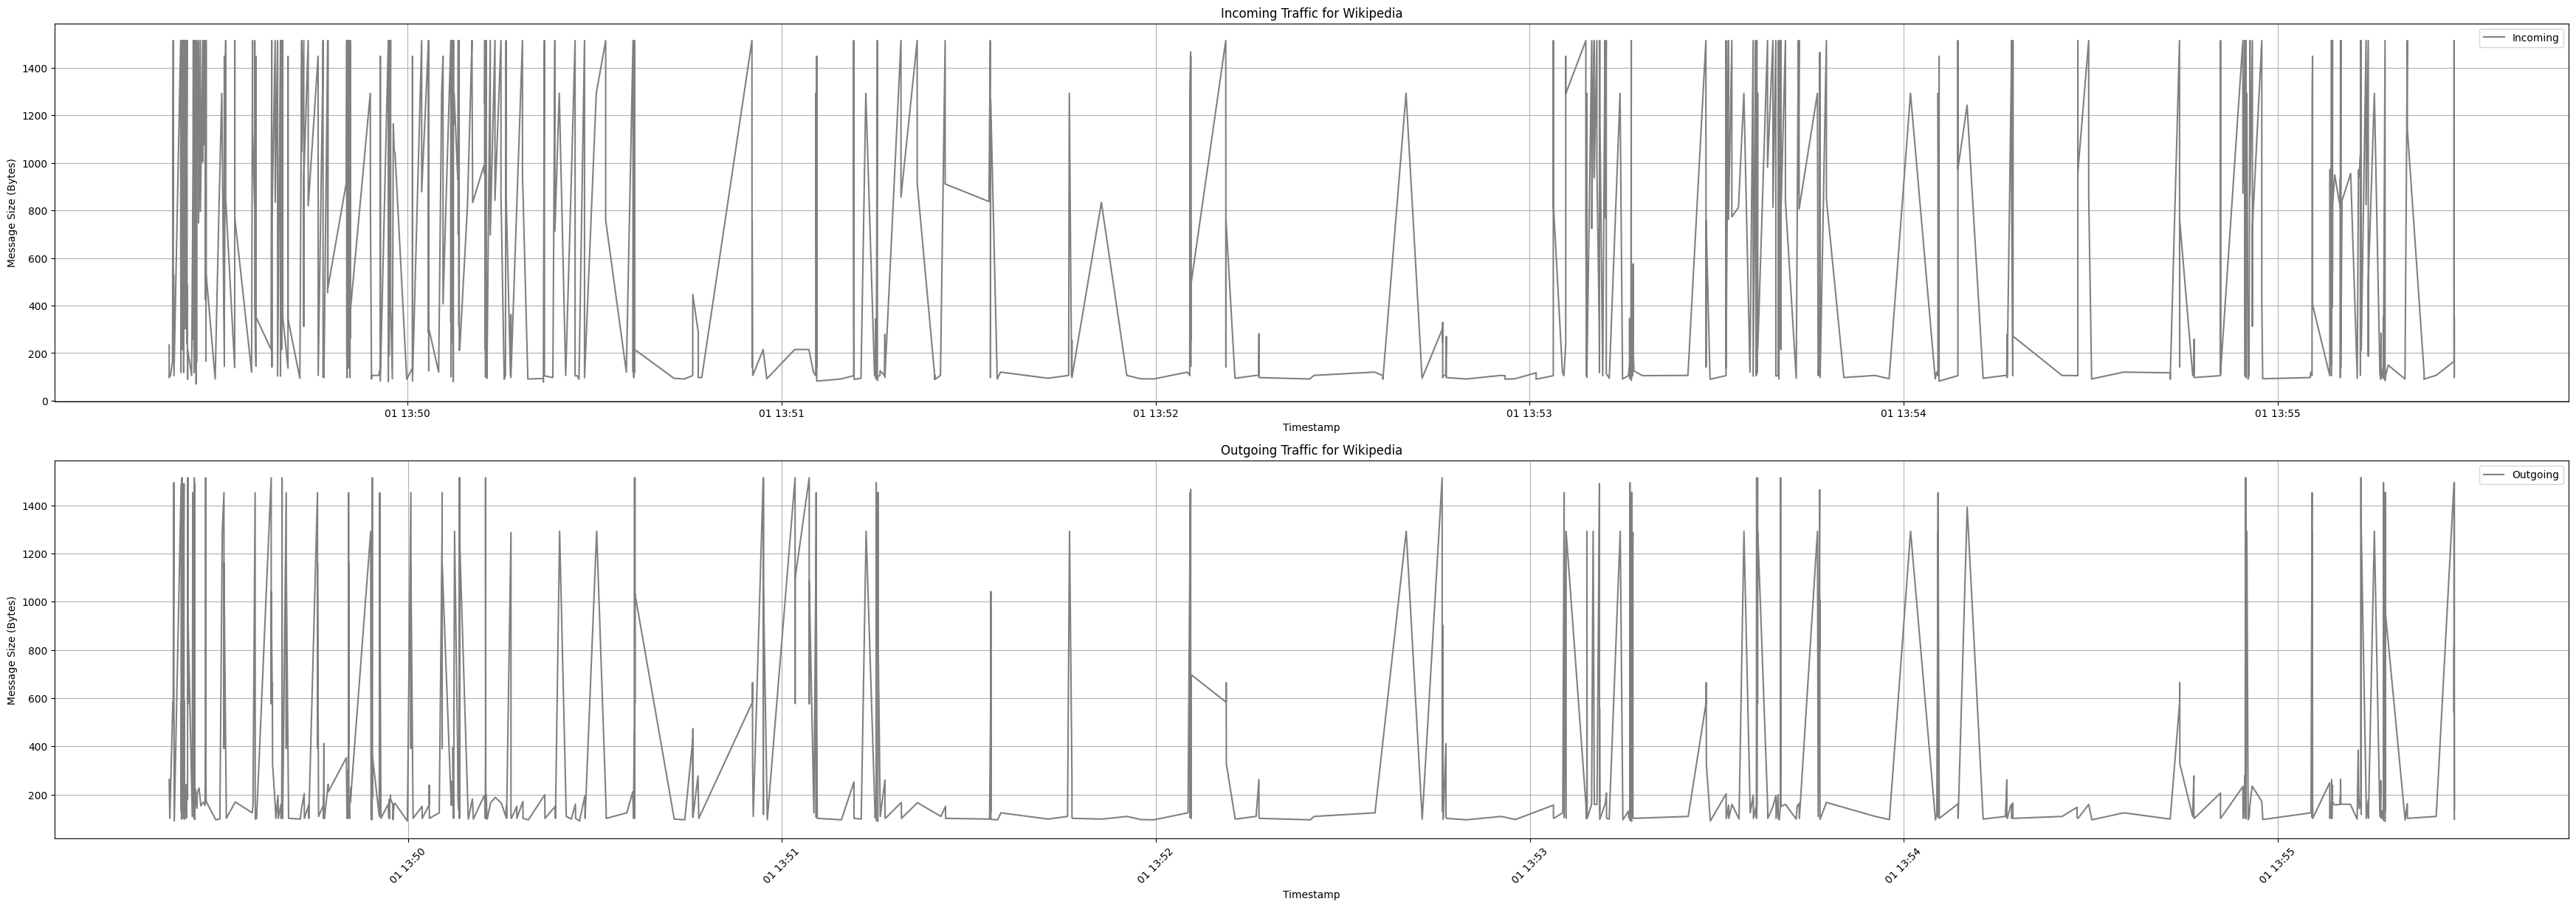

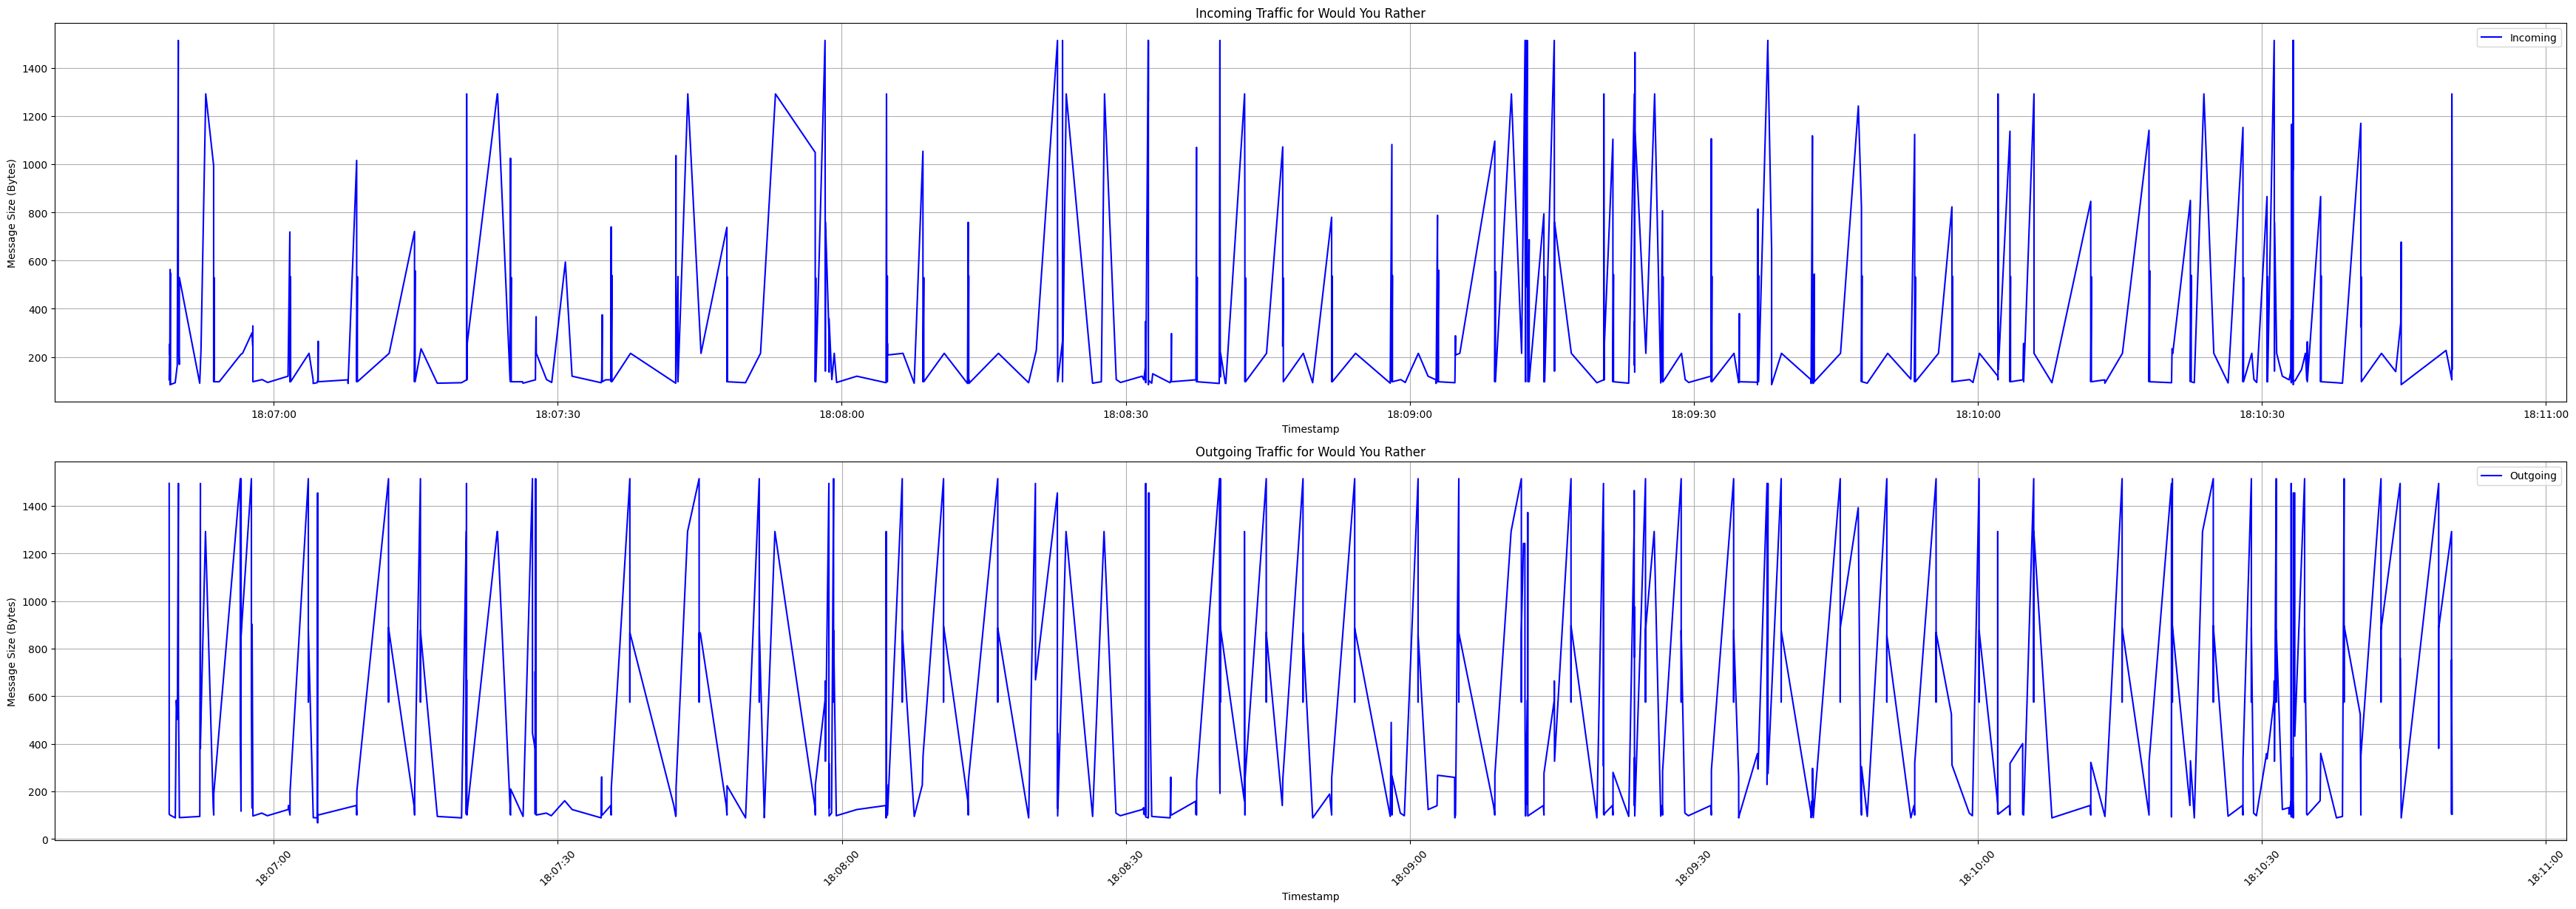

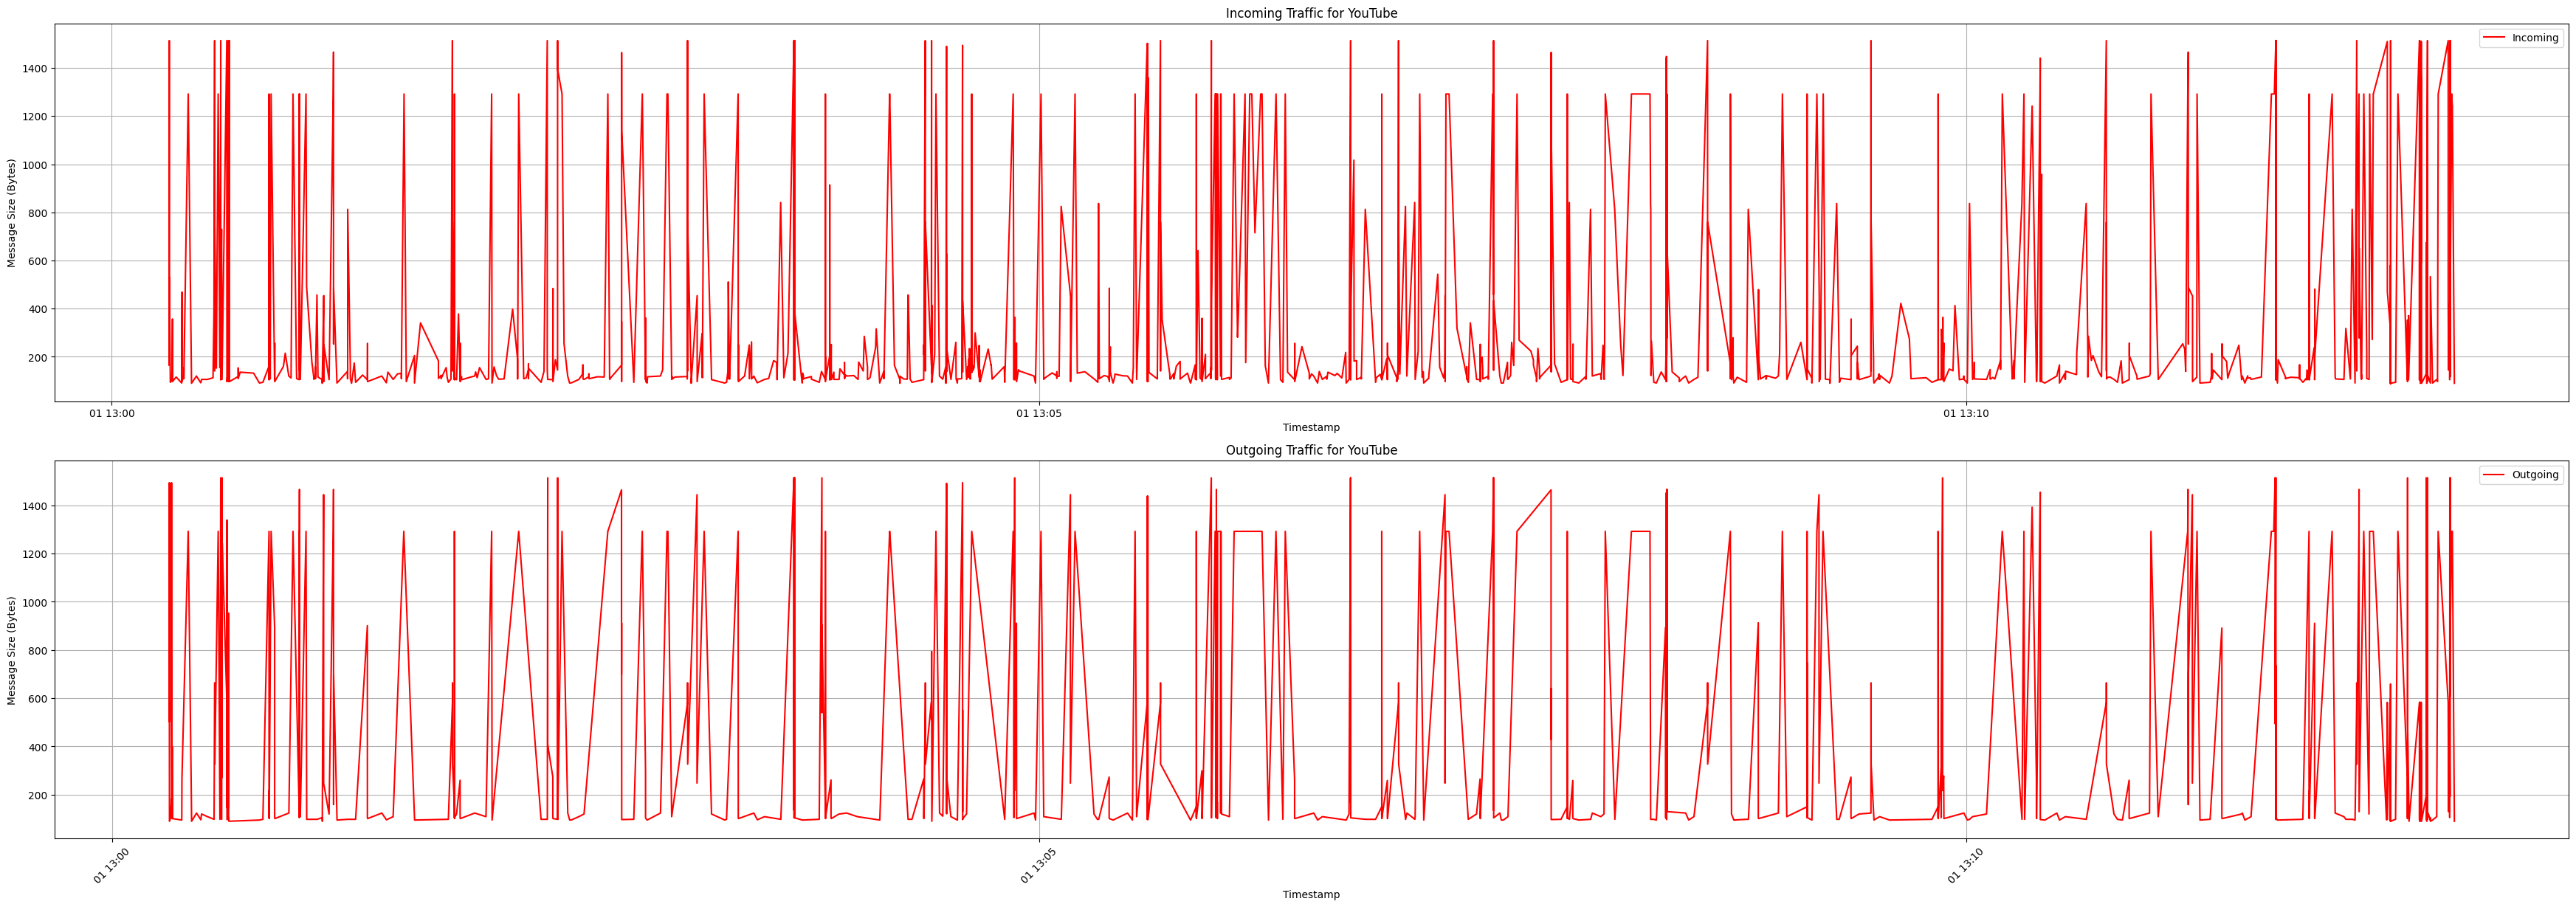

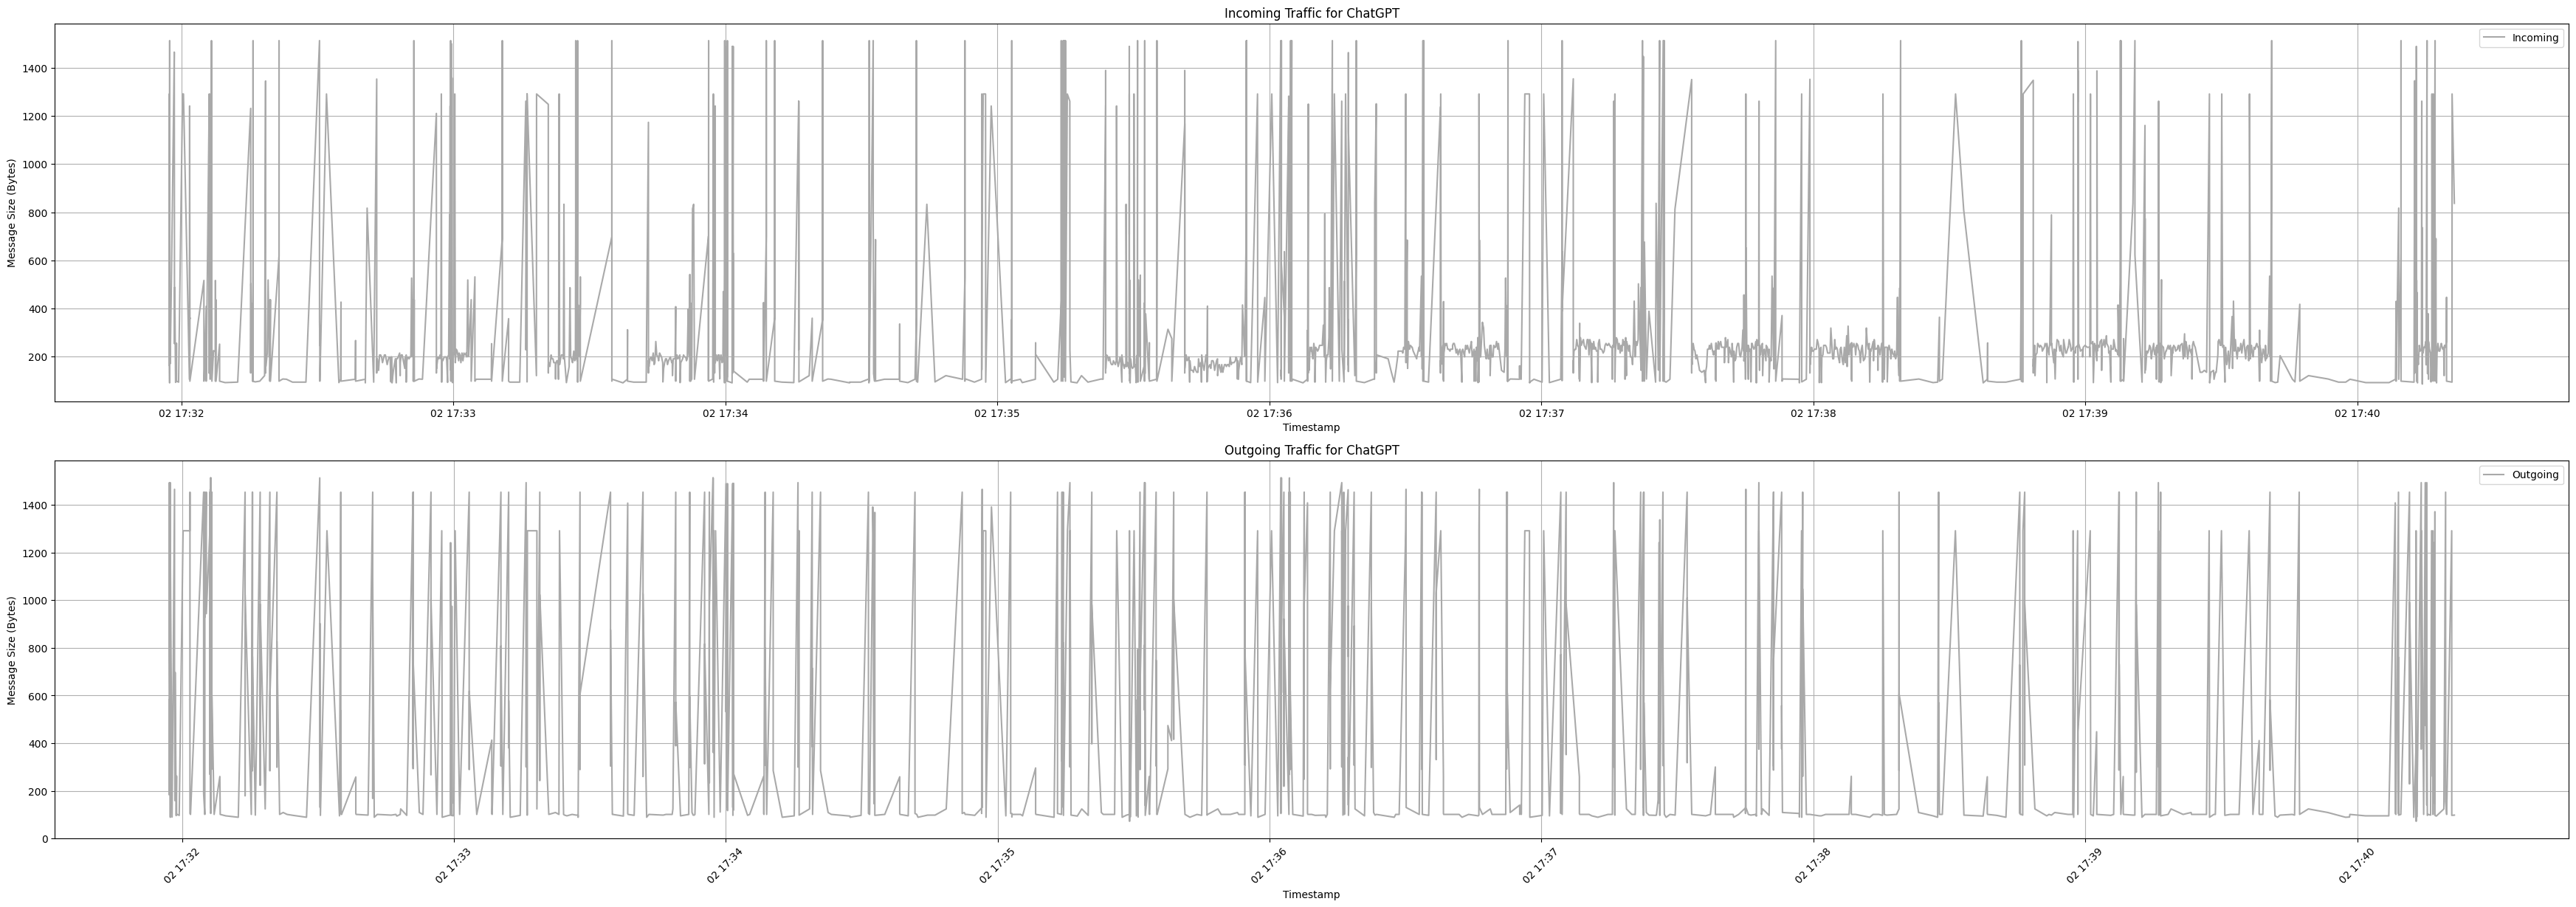

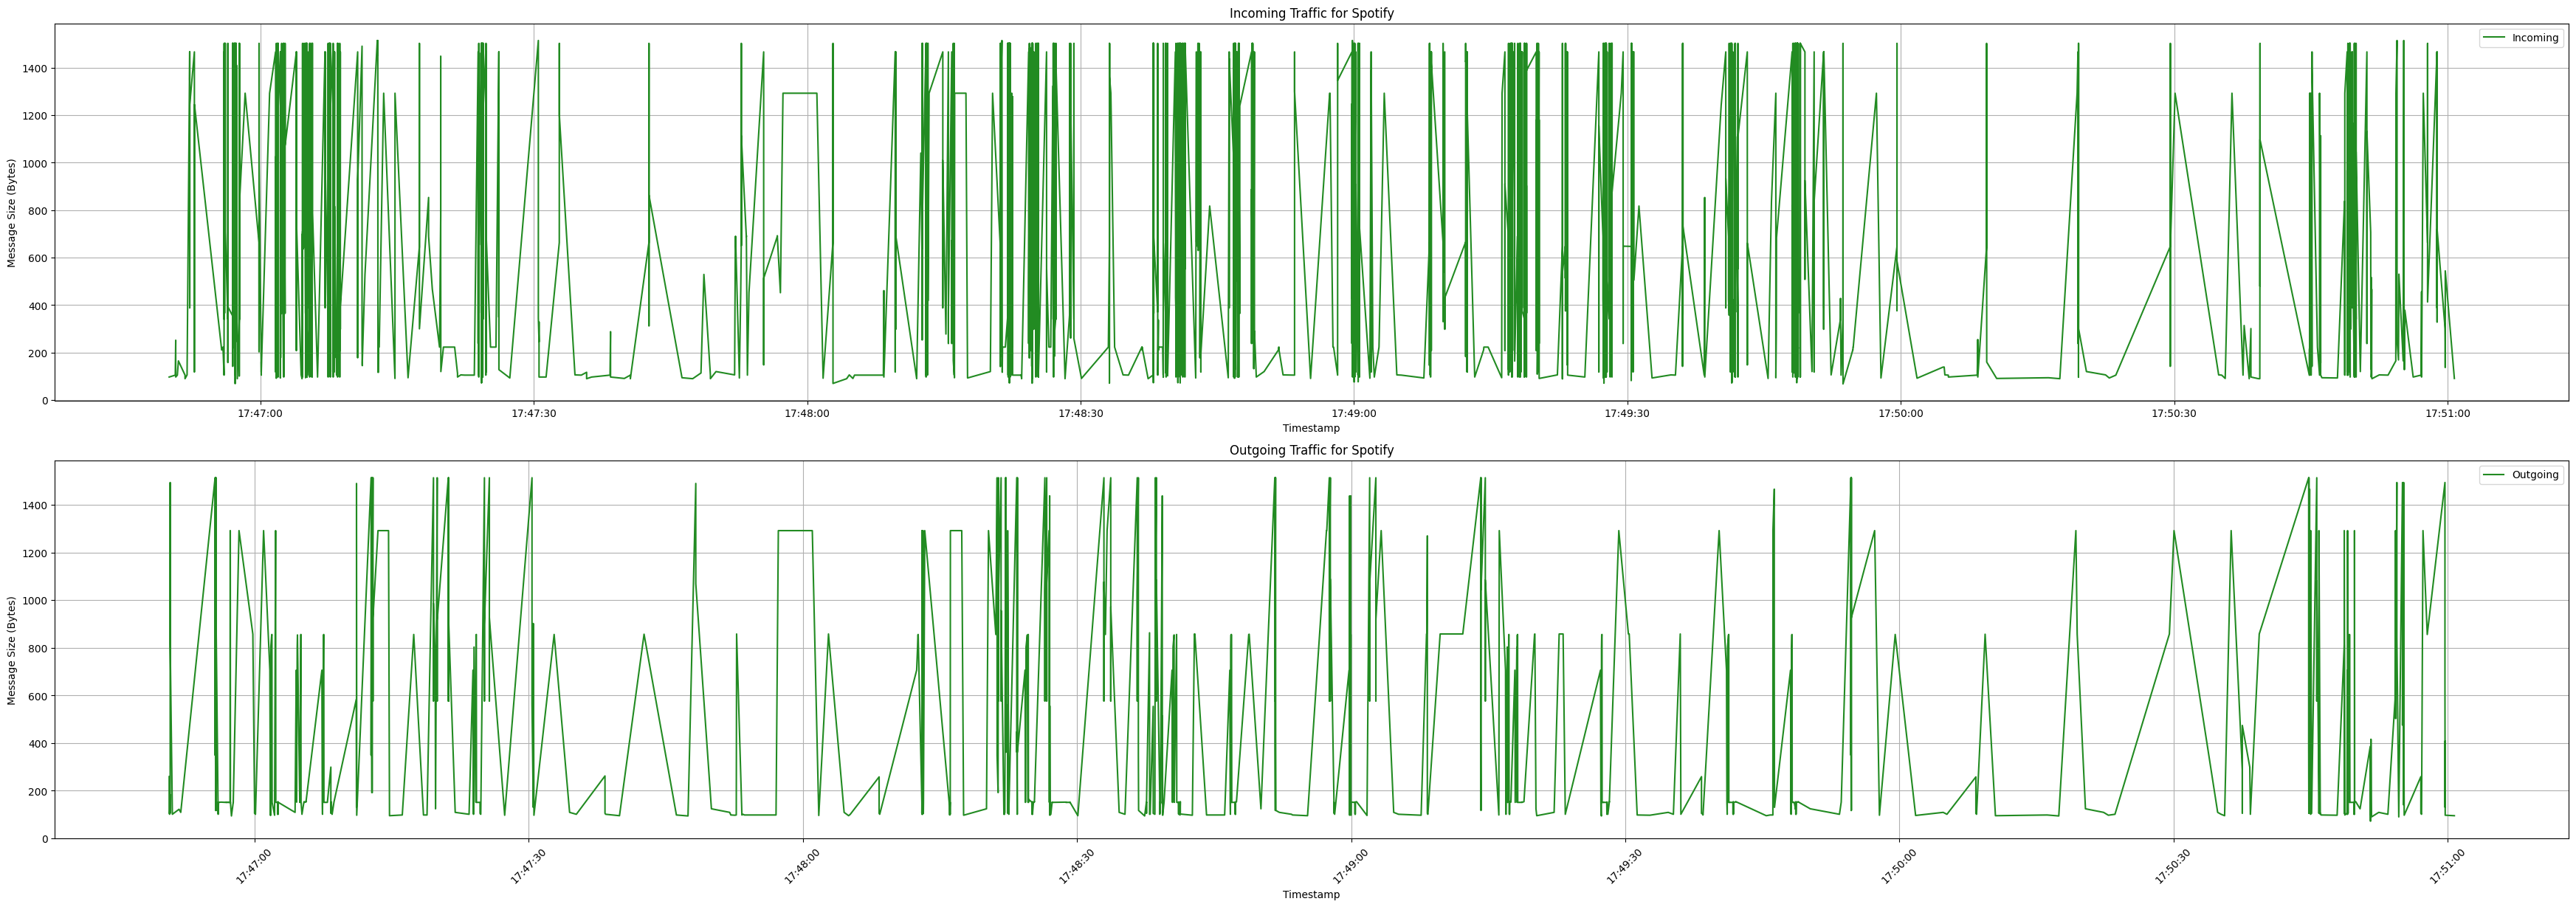

In [152]:
plot_traffic(insta, "Instagram", color='purple')
plot_traffic(reddit, "Reddit", color='orange')
plot_traffic(tetris, "Tetris", color='skyblue')
plot_traffic(wiki, "Wikipedia", color='gray')
plot_traffic(wyr, "Would You Rather", color='blue')
plot_traffic(yt, "YouTube", color='red')
plot_traffic(chat, "ChatGPT", color='darkgray')
plot_traffic(spotify, "Spotify", color='forestgreen')

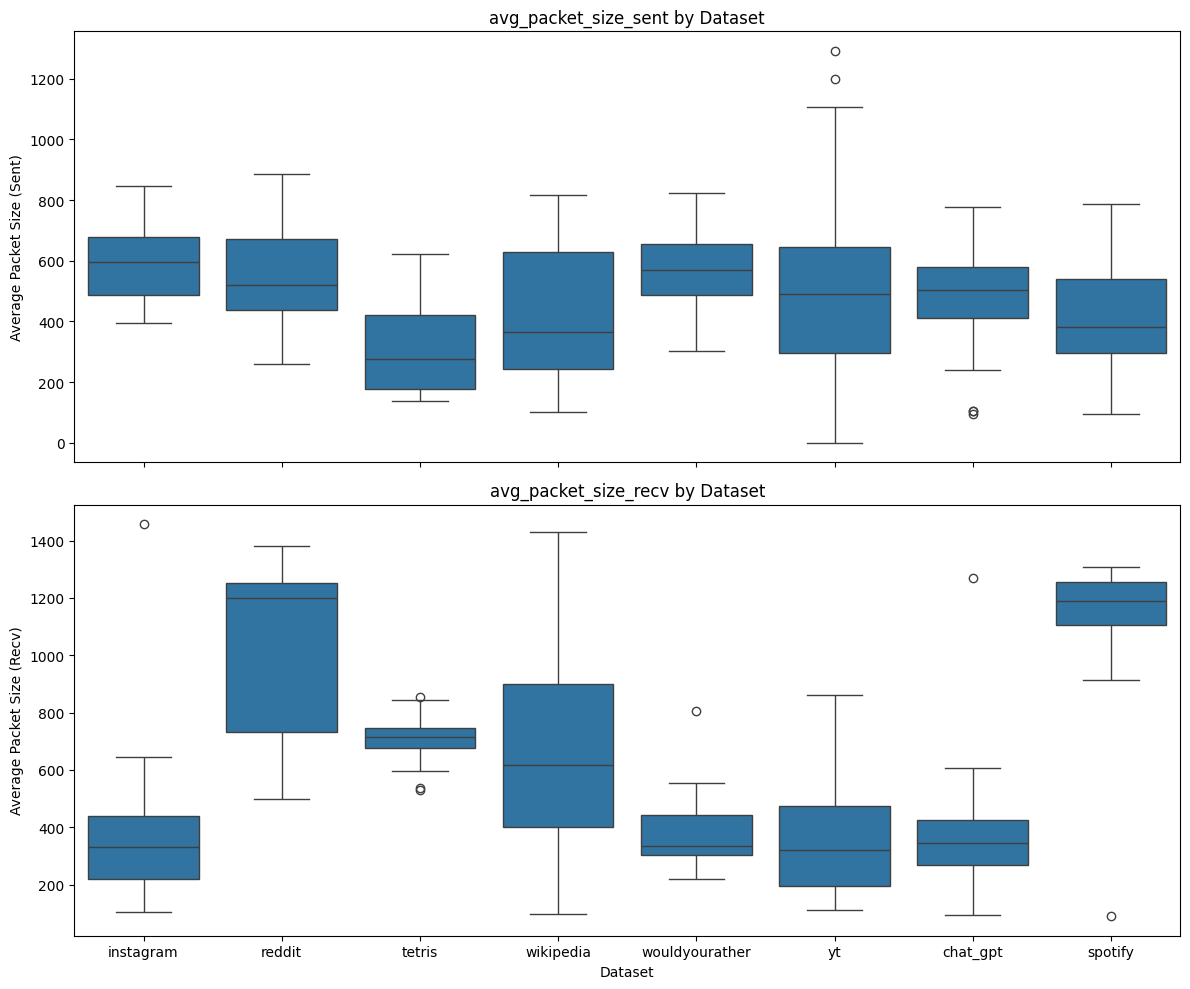

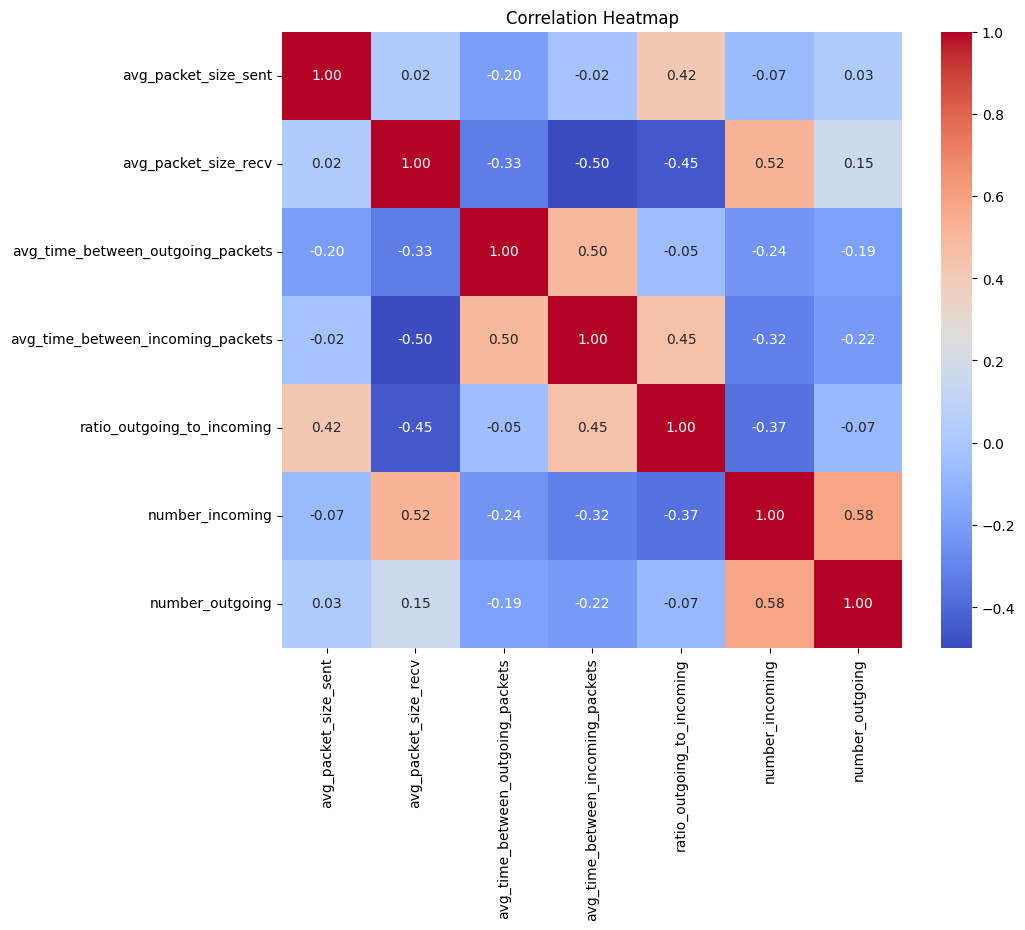

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `df` is your DataFrame and it has the features and the 'dataset' column
# Example dataset: df = pd.read_csv('your_data.csv')

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# First box plot
sns.boxplot(x='dataset', y='avg_packet_size_sent', data=features_df, ax=axes[0])
axes[0].set_title('avg_packet_size_sent by Dataset')
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Average Packet Size (Sent)')

# Second box plot
sns.boxplot(x='dataset', y='avg_packet_size_recv', data=features_df, ax=axes[1])
axes[1].set_title('avg_packet_size_recv by Dataset')
axes[1].set_xlabel('Dataset')
axes[1].set_ylabel('Average Packet Size (Recv)')

# Adjust layout
plt.tight_layout()
plt.show()
# If 'dataset' is categorical, you could do similar plots for the other variables

# For correlation heatmap (if 'dataset' is numerical, you can include it in the correlation matrix)
corr_matrix = features_df.drop('dataset', axis=1).corr()  # Drop the 'dataset' column if it's categorical
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap')
plt.show()


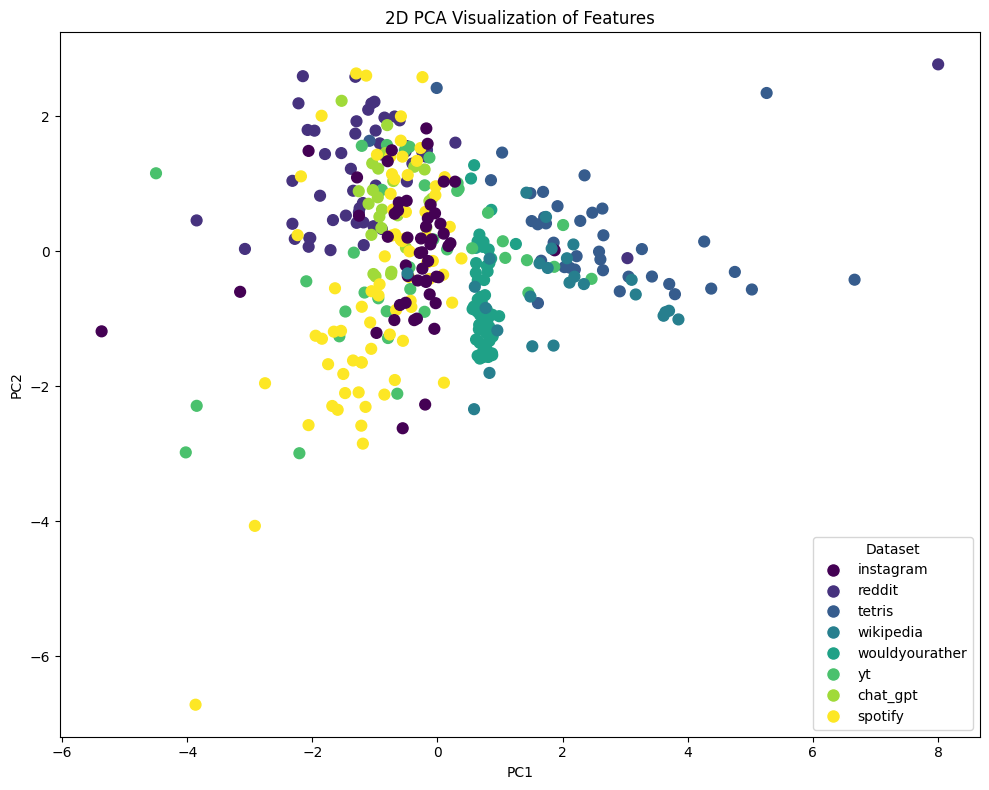

In [223]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming features_df contains your features and the 'dataset' column
X = features_df.drop('dataset', axis=1)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 2 principal components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add original 'dataset' column
pc_df['dataset'] = features_df['dataset']

# Map categorical 'dataset' labels to numeric codes for coloring
pc_df['dataset_code'] = pd.Categorical(pc_df['dataset']).codes

# Create 2D scatter plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(pc_df['PC1'], pc_df['PC2'],
                 c=pc_df['dataset_code'], cmap='viridis', s=60)

# Label axes
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA Visualization of Features')

# Add legend mapping colors to dataset labels
categories = pc_df['dataset'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(categories)))
legend_elements = [Line2D([0], [0], marker='o', color='w',
                          label=cat, markerfacecolor=col, markersize=10)
                   for cat, col in zip(categories, colors)]

plt.legend(handles=legend_elements, title='Dataset')
plt.tight_layout()
plt.show()


In [132]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Drop the target column
X = features_df.drop('dataset', axis=1)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to 3 components
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)


In [133]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Encode labels
y = pd.Categorical(features_df['dataset']).codes

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[13  2  0  0  0  2  1  1]
 [ 4 16  1  0  0  1  4  2]
 [ 1  0 11  0  2  2  0  1]
 [ 1  0  4  6  0  1  1  1]
 [ 0  0  0  0 17  0  0  0]
 [ 1  2  0  0  0  6  0  5]
 [ 1  2  0  0  0  0  6  2]
 [ 7  2  0  0  1  2  2 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.68      0.55        19
           1       0.67      0.57      0.62        28
           2       0.69      0.65      0.67        17
           3       1.00      0.43      0.60        14
           4       0.85      1.00      0.92        17
           5       0.43      0.43      0.43        14
           6       0.43      0.55      0.48        11
           7       0.57      0.53      0.55        30

    accuracy                           0.61       150
   macro avg       0.64      0.60      0.60       150
weighted avg       0.64      0.61      0.61       150

